# 50ETF期权行权前的交易机会


* 由于涨跌停的限制，临近交割时某些期权合约因其行权价不在50ETF价格所能波及的区间之内，从而“提前失效”，将其卖出便可以获得低风险甚至无风险的权利金收入。
* 根据50ETF的价格的历史分布，我们在一定的置信水平的涨跌幅度上估计50ETF价格在到期日的收盘价区间，从而锁定更多的“提前失效”的期权合约。
* 我们选取95%置信水平的涨跌幅度来估计50ETF的到期日的收盘价区间，并卖出相应的期权来构造投资组合。

In [1]:
import pandas as pd
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn
import math
from datetime import date, datetime, timedelta
%matplotlib inline

In [60]:
#这里是公用函数

# lag
def lag(data):
    lagged = np.roll(data, 1)
    # 处理第一个数据，这里可以优化成从更早的数据中取一个填上
    lagged[0] = 0.
    return lagged

# 返回对数收益率
def adj_return(pnl):
    
    lagged_pnl = lag(pnl)
    returns = np.log(pnl / lagged_pnl)
    
    # 处理inf
    returns[np.isinf(returns)] = 0.
    # 处理NaN
    returns[np.isnan(returns)] = 0.
    
    return returns

# 计算输入列的adj_return_N, data为需要计算的数据序列
# 返回连续N天的收益率
def adj_return_N(data, N):
    # 累计对数收益率
    return data.rolling(window=N, center=False).sum()

# 获取数据并处理收益率
def get_data(start='', end=''):
    
    if start == '':
        start='2013-10-21'
    
    #终止时间默认是上一个交易日
    if end == '':
        end = date.today().isoformat()
    
    data = ts.get_hist_data('510050', start=start, end=end)
    data.sort_index(axis=0, ascending=True, inplace=True)
    
    # 处理收益率
    data['adj_return'] = adj_return(data.close)
    
    return data

In [10]:
#data = get_data(start='2004-10-01')
#因为数据源较少，改用调用通联数据，有05年以来的数据
data = pd.read_csv('./data/510050.csv')

In [56]:
data.head()

,Unnamed: 0,secID,ticker,exchangeCD,secShortName,tradeDate,preClosePrice,openPrice,highestPrice,lowestPrice,closePrice,CHG,CHGPct,turnoverVol,turnoverValue,discount,discountRatio,circulationShares,accumAdjFactor,adj_return
0,0,510050.XSHG,510050,XSHG,华夏上证50ETF,2005-02-23,0.887,0.881,0.882,0.866,0.876,-0.011,-0.0124,1269742542,1111793167,0.002,0.002278,5.940000e+09,1.0,0.000000
1,1,510050.XSHG,510050,XSHG,华夏上证50ETF,2005-02-24,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,451614223,394141216,0.001,0.001140,5.768000e+09,1.0,0.000000
2,2,510050.XSHG,510050,XSHG,华夏上证50ETF,2005-02-25,0.876,0.877,0.887,0.875,0.880,0.004,0.0046,506460695,446597972,-0.002,-0.002278,5.509000e+09,1.0,0.455582
3,3,510050.XSHG,510050,XSHG,华夏上证50ETF,2005-02-28,0.880,0.878,0.879,0.870,0.872,-0.008,-0.0091,187965193,164467462,-0.003,-0.003452,5.513000e+09,1.0,-0.913248
4,4,510050.XSHG,510050,XSHG,华夏上证50ETF,2005-03-01,0.872,0.870,0.873,0.865,0.867,-0.005,-0.0057,208094456,180573596,-0.001,-0.001155,5.631000e+09,1.0,-0.575045


In [53]:
data['adj_return'] = adj_return(data.closePrice)*100

In [94]:
#处理连续两天，连续三天，以及连续五天的涨跌幅
data['adj_return2'] = adj_return_N(data.adj_return, 2)
data['adj_return3'] = adj_return_N(data.adj_return, 3)
data['adj_return5'] = adj_return_N(data.adj_return, 5)
data.fillna(0, inplace=True)

## 1. 上证50ETF的价格历史分布
我们来观察上证50ETF自2013年10月以来单天、连续两天和连续三天的涨跌幅情况。

### 1.1 上证50ETF一天涨跌幅的频率分布直方图

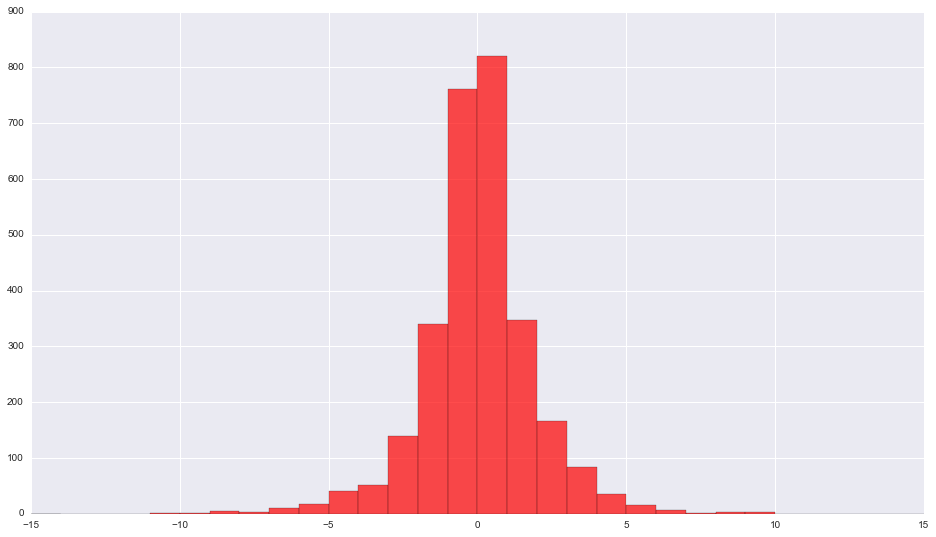

In [89]:
plt.figure(figsize=(16,9))
n, bins, patchs = plt.hist(data.adj_return, bins = np.array(range(-15, 16)), facecolor='red', alpha=0.7)

### 1.2 上证50ETF连续两天涨跌幅的频率分布直方图

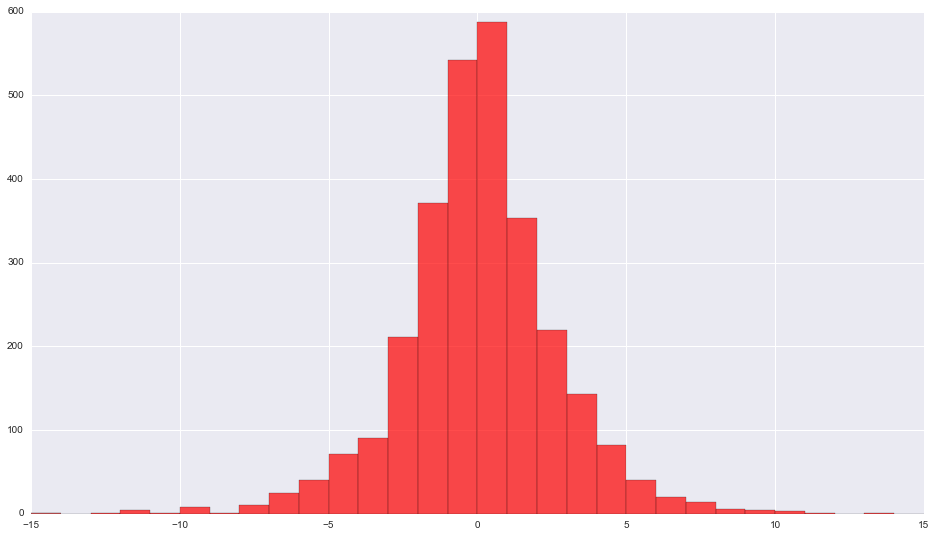

In [90]:
plt.figure(figsize=(16,9))
n, bins, patchs = plt.hist(data.adj_return2, bins = np.array(range(-15, 16)), facecolor='red', alpha=0.7)

### 1.3 上证50ETF连续三天涨跌幅的频率分布直方图

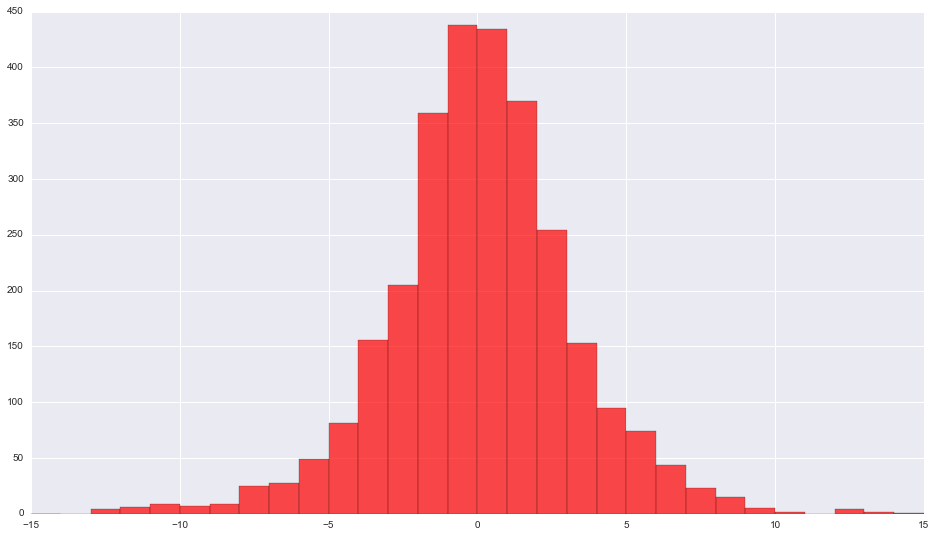

In [92]:
plt.figure(figsize=(16,9))
n, bins, patchs = plt.hist(data.adj_return3, bins = np.array(range(-15, 16)), facecolor='red', alpha=0.7)

### 1.4 上证50ETF连续五天天涨跌幅的频率分布直方图

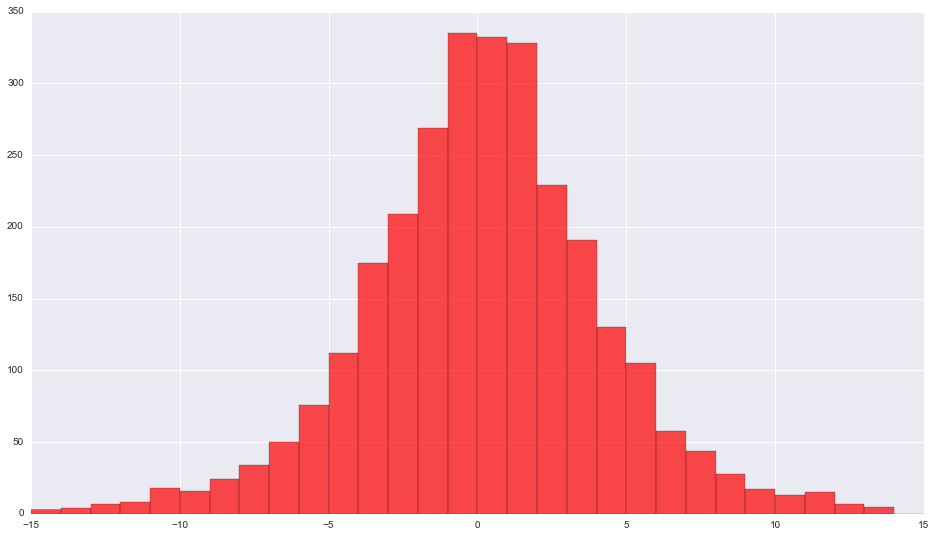

In [95]:
plt.figure(figsize=(16,9))
n, bins, patchs = plt.hist(data.adj_return5, bins = np.array(range(-15, 16)), facecolor='red', alpha=0.7)

随着时间跨度的增加，可见分布的峰度（kurtosis）逐渐增加（尾部变肥）,但是市场是否给予这种交易机会呢。一般来说不会有太多的空间，因为做市商对深度虚值期权的定价应该考虑了这种情况，就算做市商留有空间，但

## 2. 期权合约失效扫描

## 3. 组合构建

## 4. 风险分析